In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns

sns.set_theme(context='talk', 
              style='whitegrid', 
              palette='Set2',
              font_scale=1.4, 
              rc={'figure.figsize': (14, 6)})

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import plotly
pio.templates.default = 'plotly_white+presentation'



import scipy.optimize
import scipy.constants as sc

hbarc = sc.hbar*sc.speed_of_light/sc.giga/sc.electron_volt / sc.femto

from scipy.interpolate import InterpolatedUnivariateSpline


import json
import os
import glob

import sys
sys.path.append('../src')
from luscher_lib import Luscher_zeta, Kcot_luscher

from tqdm import tqdm

# load data

In [3]:
df_conf = pd.read_csv('../data/CLS_conf_inf.csv')
df_conf['a2 [fm2]'] = df_conf['a [fm]'].apply(lambda x: x**2)
df_conf['a_inv [GeV]'] = (hbarc / df_conf['a [fm]']).round(3) # add lattice unit
df_conf

,Label,N_f,beta,kappa,size_L,size_T,bdy.cond.,a [fm],m_pi [MeV],L [fm],m_pi L,m_B [GeV],N_conf,N_tsrc,N_meas,N_LapH,a2 [fm2],a_inv [GeV]
0,N300,3,3.70,0.137000,48,128,open,0.0498,422,2.4,5.1,1.19,2047,12,24564,32,0.002480,3.962
1,N202,3,3.55,0.137000,48,128,open,0.0642,412,3.1,6.4,1.17,899,8,10788,68,0.004122,3.074
2,H200,3,3.55,0.137000,32,96,open,0.0642,419,2.1,4.4,1.19,2000,8,16000,20,0.004122,3.074
3,B450,3,3.46,0.136890,32,64,periodic,0.0762,417,2.4,5.2,1.18,1612,8,25762,32,0.005806,2.590
4,H101,3,3.40,0.136760,32,96,open,0.0865,417,2.8,5.9,1.16,2016,4,12096,48,0.007482,2.281
5,U103,3,3.40,0.136760,24,128,open,0.0865,414,2.1,4.4,1.18,5658,5,45264,20,0.007482,2.281
6,A653,3,3.34,0.136572,24,48,periodic,0.0992,424,2.4,5.1,1.16,5050,4,40400,32,0.009841,1.989
7,E5,2,5.30,0.136250,32,64,periodic,0.0658,436,2.1,4.7,1.29,2000,4,16000,30,0.004330,2.999
8,E1,2,5.30,0.135500,32,64,periodic,0.0658,978,2.1,10.4,2.03,168,8,2688,30,0.004330,2.999


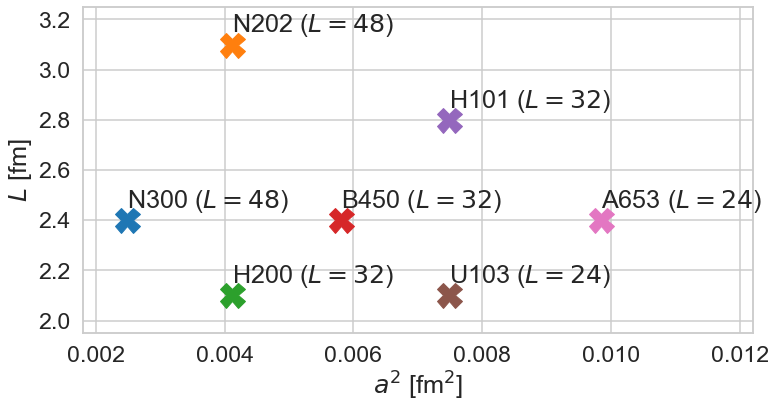

In [4]:
# for utility
lat_unit_dic = df_conf.set_index('Label')['a [fm]'].to_dict()
a_inv_dic = df_conf.set_index('Label')['a_inv [GeV]'].to_dict()
L_fm_dic = df_conf.set_index('Label')['L [fm]'].to_dict()
L_dic = df_conf.set_index('Label')['size_L'].to_dict()
pion_mass_dic = df_conf.set_index('Label')['m_pi [MeV]'].to_dict()
baryon_mass_dic = df_conf.set_index('Label')['m_B [GeV]'].to_dict()
label_list = list(df_conf['Label'])

with sns.color_palette('tab10'):
    fig, ax = plt.subplots(figsize=(12, 6))
    for label in label_list:
        if label in ['E5', 'E1']: continue
        a2 = lat_unit_dic.get(label)**2
        L_fm = L_fm_dic.get(label)
        ax.plot(a2, L_fm, 'X', ms=25)
        ax.text(a2, L_fm+0.05, fr'{label} ($L = {L_dic.get(label)}$)')
    ax.set(xlabel=r'$a^2$ [fm$^2$]', ylabel='$L$ [fm]', xlim=(0.0018, 0.0122), ylim=(1.95, 3.25))
#    fig.savefig('../figs/SU3_ensembles.png', bbox_inches='tight')

In [5]:
ld_dic = {}
for fname in glob.glob('../data/pcot_p2/*.json'):
    with open(fname, 'r') as fin:
        tmp = json.load(fin)
        ld_dic[(tmp.get('label'), tmp.get('frame'), tmp.get('level'))] = tmp

In [6]:
color_list = {'P000': 'dimgray', 'P001': 'firebrick', 'P011': 'darkorange', 'P111': 'mediumturquoise', 'P002': 'ghostwhite'}


In [29]:
L_fm_dic.get(label)

2.4

In [45]:
clist = list(sns.color_palette('coolwarm_r', 4))

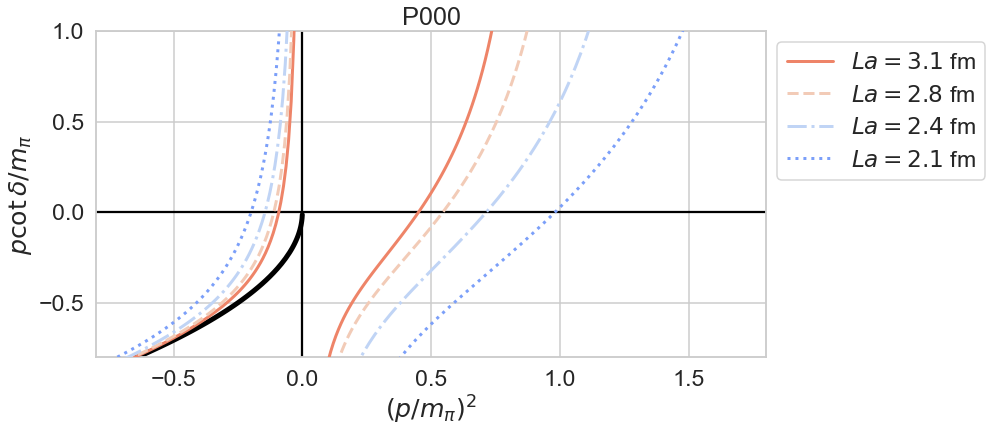

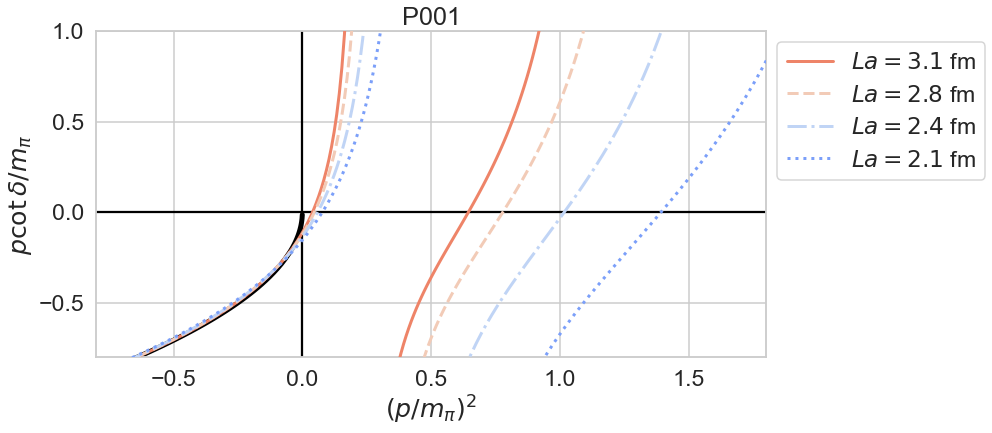

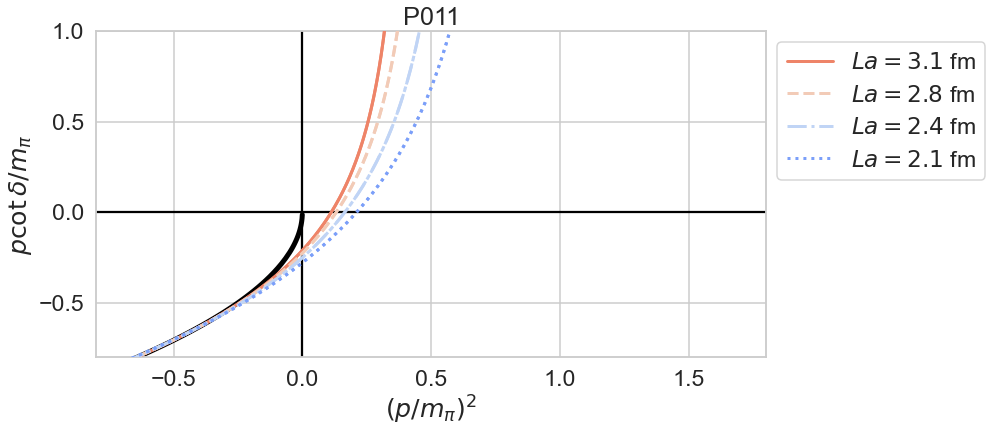

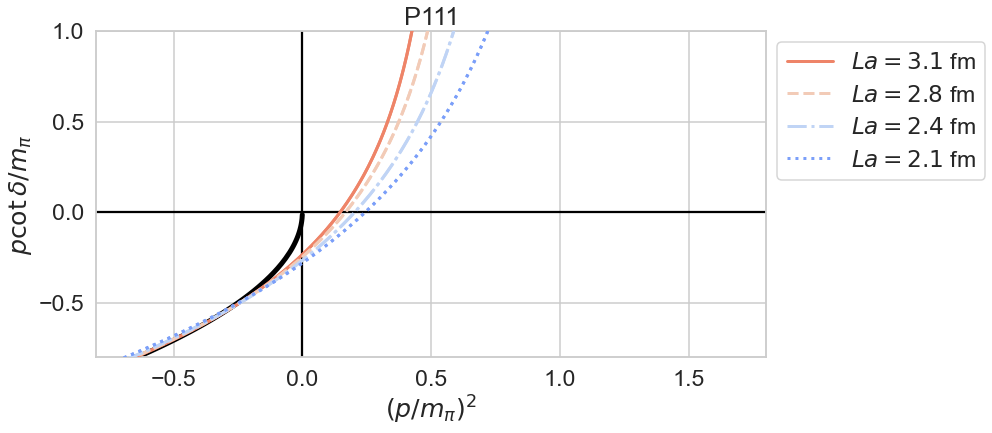

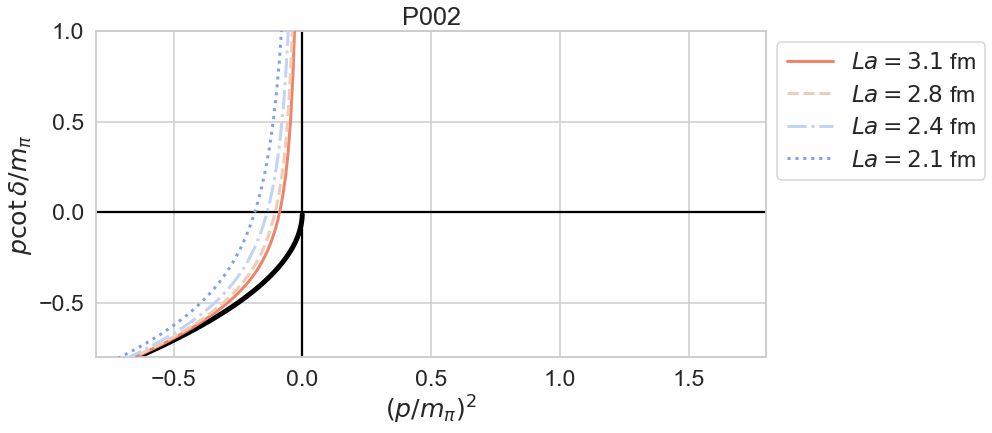

In [47]:

xlim = (-0.8, 1.8)
ylim = (-0.8, 1.0)

for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
    fig, ax = plt.subplots(figsize=(12, 6))

    for label, ls, c in zip(['N202', 'H101', 'N300', 'H200'], ['-', '--', '-.', ':'], clist):
        for level in [0, 1]:
            try:
                ld = ld_dic[(label, frame, level)]

                if level == 0:
                    lbl = fr'$La = {L_fm_dic.get(label):.1f}$ fm'
                else:
                    lbl = ''
                ax.plot(ld.get('k2mpi2_ref'), ld.get('kcot_mpi_ref'), ls=ls, color=c, lw=3, zorder=3, label=lbl)


            except:
                pass

    xbs = np.concatenate([np.linspace(xlim[0], -0.5e-1), np.linspace(-0.5e-1, -2e-4)])
    ax.plot(xbs, - np.sqrt(-xbs), color='black', ls='-', lw=5)

    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set(ylim=ylim, xlim=xlim, xlabel=r'$(p/m_\pi)^2$', ylabel=r'$p\cot\delta/m_\pi$',
          title=rf'{frame}')
